# Assignment 2021-2022

## Francisco Perestrello | 39001

## Question I.

In [ ]:
#1.
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import minimize

Mounted at /content/drive


In [4]:
#2.
def get_ff30_returns():
    """
    Load and format the Ken French 30 Industry Portfolios Value Weighted Monthly Returns
    """
    ff30 = pd.read_csv("/content/drive/MyDrive/AssetManagement2022/data/ind30_m_vw_rets.csv", header=0, index_col=0)/100
    ff30.index = pd.to_datetime(ff30.index, format="%Y%m").to_period('M')
    ff30.columns = ff30.columns.str.strip()
    return ff30

ff30 = get_ff30_returns()['1980':]

In [5]:
#3.
def get_rf():
    """
    import the time series of the risk-free rate
    """
    rf = pd.read_excel("/content/drive/MyDrive/AssetManagement2022/data/rf.xlsx", header=0, index_col=0)
    rf.index = pd.to_datetime(rf.index, format="%Y%m").to_period('M')
    rf.columns = rf.columns.str.strip()
    return rf

def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def gmv(cov):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov)

def weight_gmv_shrink(r, rf):
    """
    Returns the weights of the portfolio based on the asset returns "r" as a DataFrame and the risk free rate "rf"
    """
    n = len(r.columns)
    cov = shrinkage_cov(r)
    return pd.Series(gmv(cov), index=r.columns)

#acho que é isto, mas kinda confusing

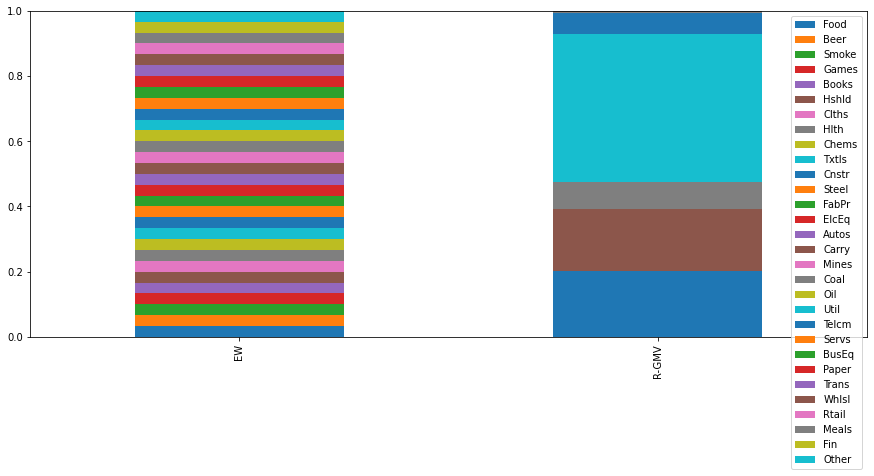

In [18]:
#4.
def weight_ew(r,rf):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame and the risk free rate "rf"
    """
    n = len(r.columns)
    return pd.Series(1/n, index=r.columns)

wts = pd.DataFrame({
    "EW": weight_ew(ff30, get_rf()),
    "R-GMV": weight_gmv_shrink(ff30, get_rf()),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=True);

In [19]:
wts

,EW,R-GMV
Food,0.033333,2.022872e-01
Beer,0.033333,5.425646e-04
Smoke,0.033333,0.000000e+00
Games,0.033333,0.000000e+00
Books,0.033333,5.740874e-14
Hshld,0.033333,1.885808e-01
Clths,0.033333,1.055428e-13
Hlth,0.033333,8.306223e-02
Chems,0.033333,3.342785e-13
Txtls,0.033333,0.000000e+00


**Answer:** When comparing the R-GMV weight distribution to the EW, the differences are obvious. By construction, the EW plot shows us 30 bars of equal size. Through the Robust Global Minimum Variance Portfolio, however, we see that is composed of a 'top 5', which completely take over the rest. With Utilities bing the industry with the largest weight (45,3%), Food (20,2%), Consumer Goods (18,9%), Healthcare (8,3%), and Telecommunications (6,6%) make the rest of the top 5. The main goal of the R-GMV method is to overcome some limitations of the normal Minimum Variance Portfolio. The problem with this portfolio-building strategy is that it uses a Sample Covariance Matrix to estimate weights, which doens't do well when returns are not Gaussian. Financial data tends to be heavy-tailed and have many outliers. Thus, this alternative method (R-GMV) uses a covariance estimator that shrinks between the Constant Correlation Estimator and the Sample Covariance. This is known as the Elton/Gruber Constant Correlation Model.

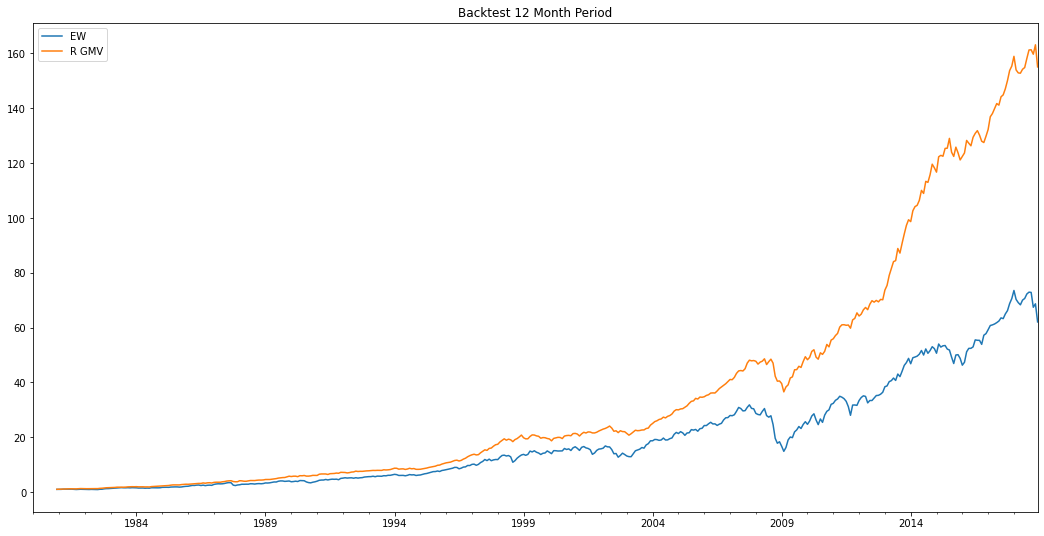

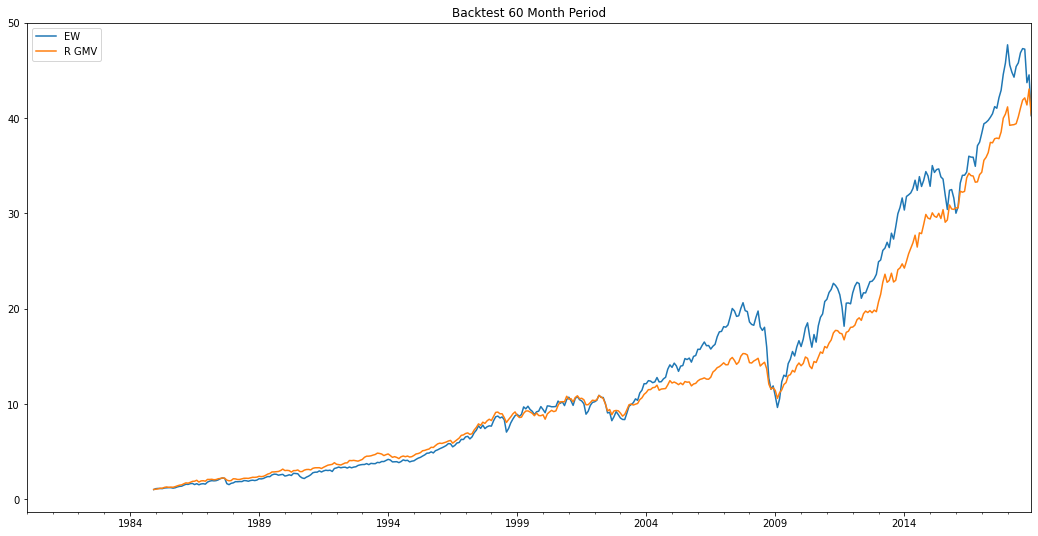

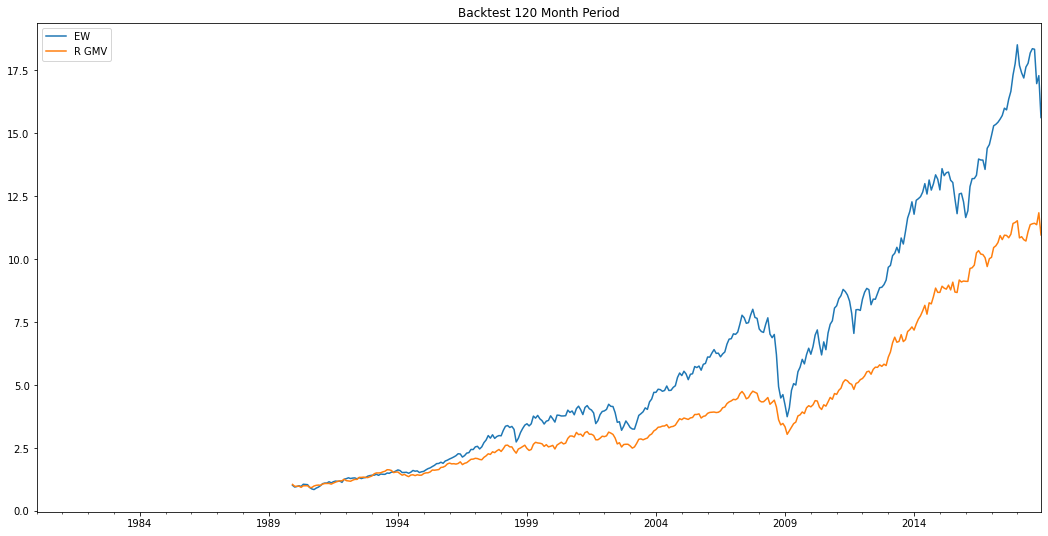

In [7]:
#5.
def backtest_ws(r, rf, estimation_window=60, weighting=weight_gmv_shrink):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window+1)]
    # windows is a list of tuples which gives us the (integer) location of the start and stop (non inclusive)
    # for each estimation window
    weights = [weighting(r.iloc[win[0]:win[1]], rf.iloc[win[0]:win[1]]) for win in windows]
    # List -> DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window-1:].index, columns=r.columns)
    # return weights
    returns = (weights * r).sum(axis="columns",  min_count=1) # mincount is to generate NAs if all inputs are NAs
    return returns

ew_ret_12 = backtest_ws(ff30, get_rf(), estimation_window=12, weighting=weight_ew)
r_gmv_ret_12 = backtest_ws(ff30, get_rf(), estimation_window=12, weighting=weight_gmv_shrink)
btr_12 = pd.DataFrame({"EW": ew_ret_12, "R GMV": r_gmv_ret_12})
(1+btr_12).cumprod().plot(figsize=(18,9), title = "Backtest 12 Month Period")

ew_ret_60 = backtest_ws(ff30, get_rf(), estimation_window=60, weighting=weight_ew)
r_gmv_ret_60 = backtest_ws(ff30, get_rf(), estimation_window=60, weighting=weight_gmv_shrink)
btr_60 = pd.DataFrame({"EW": ew_ret_60, "R GMV": r_gmv_ret_60})
(1+btr_60).cumprod().plot(figsize=(18,9), title = "Backtest 60 Month Period")

ew_ret_120 = backtest_ws(ff30, get_rf(), estimation_window=120, weighting=weight_ew)
r_gmv_ret_120 = backtest_ws(ff30, get_rf(), estimation_window=120, weighting=weight_gmv_shrink)
btr_120 = pd.DataFrame({"EW": ew_ret_120, "R GMV": r_gmv_ret_120})
(1+btr_120).cumprod().plot(figsize=(18,9), title = "Backtest 120 Month Period")

**Answer:** By taking a look at the plots produced and comparing them with those of Lab2 session, we can see that the performance of the GMV improved by using an alternative method to calculate the covariance matrix (R-GMV). We can also see that as the estimation window increases, the investment starts later - for 12 months the investment starts in 1981, while for the largest estimation window the investment only starts waround 1990. It can also be seen that the R-GMV strategy consistently outperforms the EW strategy for the smallest estimation window, but loses its outperformance when the window is incresed, even underperforming the EW when considering an estimation window of 120 months.

## Question II.

In [8]:
#1.
brka_d = pd.read_csv("/content/drive/MyDrive/AssetManagement2022/data/brka_d_ret.csv", parse_dates=True, index_col=0)

def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())

brka_m = brka_d.resample('M').apply(compound).to_period('M')

In [9]:
#2.
def get_fff_returns():
    """
    Load the Fama-French Research Factor Monthly Dataset
    """
    rets = pd.read_csv("/content/drive/MyDrive/AssetManagement2022/data/F-F_Research_Data_Factors_m.csv",
                       header=0, index_col=0, na_values=-99.99)/100
    rets.index = pd.to_datetime(rets.index, format="%Y%m").to_period('M')
    return rets

fff = get_fff_returns()

In [37]:
#3.
import statsmodels.api as sm

# Case 1 -> Time Period 1990-2002
brka_excess_1990_2002 = brka_m["1990":"2002"] - fff.loc["1990":"2002", ['RF']].values
mkt_excess_1990_2002 = fff.loc["1990":"2002",['Mkt-RF']]
exp_var_1990_2002 = mkt_excess_1990_2002.copy()
exp_var_1990_2002["Constant"] = 1
lm_1990_2002 = sm.OLS(brka_excess_1990_2002, exp_var_1990_2002).fit()
replicating_port_capm_1990_2002 = brka_m['1990':'2002'].values - lm_1990_2002.params[0] * (mkt_excess_1990_2002.values + fff.loc["1990":"2002", ['RF']].values) - (1 - lm_1990_2002.params[0]) * fff.loc["1990":"2002", ['RF']].values
alpha_1990_2002 = replicating_port_capm_1990_2002.mean()
alpha_1990_2002_ann = (1+alpha_1990_2002)**12 - 1
te_1990_2002 = replicating_port_capm_1990_2002.std()
te_1990_2002_ann = te_1990_2002*np.sqrt(12)
IR_1990_2002 = alpha_1990_2002/te_1990_2002
IR_1990_2002_ann = alpha_1990_2002_ann/te_1990_2002_ann

# Case 2 -> Time Period 2003-2018
brka_excess_2003_2018 = brka_m["2003":"2018"] - fff.loc["2003":"2018", ['RF']].values
mkt_excess_2003_2018 = fff.loc["2003":"2018",['Mkt-RF']]
exp_var_2003_2018 = mkt_excess_2003_2018.copy()
exp_var_2003_2018["Constant"] = 1
lm_2003_2018 = sm.OLS(brka_excess_2003_2018, exp_var_2003_2018).fit()
replicating_port_capm_2003_2018 = brka_m['2003':'2018'].values - lm_2003_2018.params[0] * (mkt_excess_2003_2018.values + fff.loc["2003":"2018", ['RF']].values) - (1 - lm_2003_2018.params[0]) * fff.loc["2003":"2018", ['RF']].values
alpha_2003_2018 = replicating_port_capm_2003_2018.mean()
alpha_2003_2018_ann = (1+alpha_2003_2018)**12 - 1
te_2003_2018 = replicating_port_capm_2003_2018.std()
te_2003_2018_ann = te_2003_2018*np.sqrt(12)
IR_2003_2018 = alpha_2003_2018/te_2003_2018
IR_2003_2018_ann = alpha_2003_2018_ann/te_2003_2018_ann

# Case 3 -> Full Sample
brka_excess_full_sample = brka_m["1990":"2018"] - fff.loc["1990":"2018", ['RF']].values
mkt_excess_full_sample = fff.loc["1990":"2018",['Mkt-RF']]
exp_var_full_sample = mkt_excess_full_sample.copy()
exp_var_full_sample["Constant"] = 1
lm_full_sample = sm.OLS(brka_excess_full_sample, exp_var_full_sample).fit()
replicating_port_capm_full_sample = brka_m['1990':'2018'].values - lm_full_sample.params[0] * (mkt_excess_full_sample.values + fff.loc["1990":"2018", ['RF']].values) - (1 - lm_full_sample.params[0]) * fff.loc["1990":"2018", ['RF']].values
alpha_full_sample = replicating_port_capm_full_sample.mean()
alpha_full_sample_ann = (1+alpha_full_sample)**12 - 1
te_full_sample = replicating_port_capm_full_sample.std()
te_full_sample_ann = te_full_sample*np.sqrt(12)
IR_full_sample = alpha_full_sample/te_full_sample
IR_full_sample_ann = alpha_full_sample_ann/te_full_sample_ann

In [38]:
alpha_1990_2002_ann, te_1990_2002_ann, IR_1990_2002_ann, lm_1990_2002.params

(0.12025281623486417,
 0.2223990019435926,
 0.5407075354832935,
 Mkt-RF      0.573378
 Constant    0.009508
 dtype: float64)

In [39]:
alpha_2003_2018_ann, te_2003_2018_ann, IR_2003_2018_ann, lm_2003_2018.params

(0.03939240946299982,
 0.13525768346225195,
 0.2912397170693342,
 Mkt-RF      0.587269
 Constant    0.003225
 dtype: float64)

In [40]:
alpha_full_sample_ann, te_full_sample_ann, IR_full_sample_ann, lm_full_sample.params

(0.07531427984426986,
 0.179946839759673,
 0.41853627407325095,
 Mkt-RF      0.577946
 Constant    0.006069
 dtype: float64)

**Answer:** By looking at the results, we see that in the period of 1990-2002, the annualized alpha was 12,03%, the annualized tracking error was 22,24%, and the annualized IR was 0,54. Comparing these to the period of 2003-2018, we see that they were 3,94%, 13,53%, and 0,29, respectively. This lets us conclude that the portfolio performed much better between 1990 and 2002 than in 2003-2018, as both the alpha and the IR are greatly superior.
As for the whole sample, we see that the annualized alpha return was 7,53%, which means that, on average, the portfolio is outperforming a portfolio composed by 57,8% invested in the market and 42,2% invested in T-Bills by 7,53%. Nonetheless, this extra return comes with a greater tracking error. The annualized tracking error of the portfolio in the whole sample (17,99%) is signifincantly higher than the benchmark of 6% which means the tracking error isn't considered inapproriate for performance analysis - a high tracking error means the portfolio can't conistently track the index. This could imply that Berkshire Hathaway may have taken additional risk factors to earn that extra alpha return. Finally, we see that the annualized information ratio is 0,42 for this period, which altough relatively low, is still acceptable.

In [41]:
#4.
# Case 1 -> Time Period 1990-2002
exp_var_1990_2002["Value"] = fff.loc["1990":"2002",['HML']]
exp_var_1990_2002["Size"] = fff.loc["1990":"2002",['SMB']]
lm_1990_2002 = sm.OLS(brka_excess_1990_2002, exp_var_1990_2002).fit()
replicating_port_ff3_1990_2002 = brka_m['1990':'2002'].values - lm_1990_2002.params[0] * (mkt_excess_1990_2002.values + fff.loc["1990":"2002", ['RF']].values) - (1 - lm_1990_2002.params[0]) * fff.loc["1990":"2002", ['RF']].values - lm_1990_2002.params[2] * fff.loc["1990":"2002", ['HML']].values - lm_1990_2002.params[3] * fff.loc["1990":"2002", ['SMB']].values
alpha_1990_2002 = replicating_port_ff3_1990_2002.mean()
alpha_1990_2002_ann = (1+alpha_1990_2002)**12 - 1
te_1990_2002 = replicating_port_ff3_1990_2002.std()
te_1990_2002_ann = te_1990_2002*np.sqrt(12)
IR_1990_2002 = alpha_1990_2002/te_1990_2002
IR_1990_2002_ann = alpha_1990_2002_ann/te_1990_2002_ann

# Case 2 -> Time Period 2003-2018
exp_var_2003_2018["Value"] = fff.loc["2003":"2018",['HML']]
exp_var_2003_2018["Size"] = fff.loc["2003":"2018",['SMB']]
lm_2003_2018 = sm.OLS(brka_excess_2003_2018, exp_var_2003_2018).fit()
replicating_port_ff3_2003_2018 = brka_m['2003':'2018'].values - lm_2003_2018.params[0] * (mkt_excess_2003_2018.values + fff.loc["2003":"2018", ['RF']].values) - (1 - lm_2003_2018.params[0]) * fff.loc["2003":"2018", ['RF']].values - lm_2003_2018.params[2] * fff.loc["2003":"2018", ['HML']].values - lm_2003_2018.params[3] * fff.loc["2003":"2018", ['SMB']].values
alpha_2003_2018 = replicating_port_ff3_2003_2018.mean()
alpha_2003_2018_ann = (1+alpha_2003_2018)**12 - 1
te_2003_2018 = replicating_port_ff3_2003_2018.std()
te_2003_2018_ann = te_2003_2018*np.sqrt(12)
IR_2003_2018 = alpha_2003_2018/te_2003_2018
IR_2003_2018_ann = alpha_2003_2018_ann/te_2003_2018_ann

# Case 3 -> Full Sample
exp_var_full_sample["Value"] = fff.loc["1990":"2018",['HML']]
exp_var_full_sample["Size"] = fff.loc["1990":"2018",['SMB']]
lm_full_sample = sm.OLS(brka_excess_full_sample, exp_var_full_sample).fit()
replicating_port_ff3_full_sample = brka_m['1990':'2018'].values - lm_full_sample.params[0] * (mkt_excess_full_sample.values + fff.loc["1990":"2018", ['RF']].values) - (1 - lm_full_sample.params[0]) * fff.loc["1990":"2018", ['RF']].values - lm_full_sample.params[2] * fff.loc["1990":"2018", ['HML']].values - lm_full_sample.params[3] * fff.loc["1990":"2018", ['SMB']].values
alpha_full_sample = replicating_port_ff3_full_sample.mean()
alpha_full_sample_ann = (1+alpha_full_sample)**12 - 1
te_full_sample = replicating_port_ff3_full_sample.std()
te_full_sample_ann = te_full_sample*np.sqrt(12)
IR_full_sample = alpha_full_sample/te_full_sample
IR_full_sample_ann = alpha_full_sample_ann/te_full_sample_ann


In [42]:
alpha_1990_2002_ann, te_1990_2002_ann, IR_1990_2002_ann, lm_1990_2002.params

(0.08252279788836825,
 0.19668712314789438,
 0.41956380553859196,
 Mkt-RF      0.830573
 Constant    0.006630
 Value       0.512478
 Size       -0.494623
 dtype: float64)

In [43]:
alpha_2003_2018_ann, te_2003_2018_ann, IR_2003_2018_ann, lm_2003_2018.params

(0.045124121298642184,
 0.12997004098866557,
 0.3471886363610316,
 Mkt-RF      0.602714
 Constant    0.003685
 Value       0.357713
 Size       -0.321818
 dtype: float64)

In [44]:
alpha_full_sample_ann, te_full_sample_ann, IR_full_sample_ann, lm_full_sample.params

(0.06377640944248109,
 0.16433663469319607,
 0.38808394465145746,
 Mkt-RF      0.709605
 Constant    0.005165
 Value       0.405283
 Size       -0.482937
 dtype: float64)

**Answer:** By adding the two extra factors to our benchmark, we expect that the tracking error is reduced. In fact, the annualized tracking error for the full period decreased to 16,43%, which is still quite large, although better. As for the annualized alpha, it is now 6,38%. Finally, the IR dropped to 0,39. This drop, albeit low, could signal that hte fund is not as good at beating the market as initially thought. This happens as the two new factors come to help explain returns a bit better. Using the CAPM, the replicating portfolios for the three periods had somewhat consistent ratios for the market and the T-Bills. However, after adding two new factors and jumping into the FF3 framework, we see that the ratios now change significantly throughout the different periods. For the full period, we find that for each dollar, the fund invests 71 cents in the market, 29 cents in T-Bills, 41 cents in Value stocks, negative 41 cents in Growth stocks, 48 cents in large cap stocks and another negative 48 cents in small cap stocks. This leads us to conclude that the fund was biased towards large and value stocks through the full period, which is consistent with the fact that Warren Buffet is a value investor.

For the 1990-2002 period, the fund had an annual alpha return of 8,25%, an annual tracking error of 19,67%, and an annual information ratio of 0,42. During this period, for each dollar invested, the fund would allocate 83 cents to the market, 17 cents to the T-Bills, 51 cents to value stocks, negative 51 cents in growth stocks, 49 cents in large cap stocks, and, again, another negative 49 cents in small cap stocks.

The analysis is similar for the 2003-2018 period. We found an annual alpha return of 4,51%, an annual tracking error of 12,99%, and an annual information ratio of 0,35. For each dollar invested, the fund would allocate 60 cents to the market, 40 cents to T-Bills, 35 cents to value stocks, negative 35 cents in growth stocks, 32 cents in large cap stocks, and a final negative 32 cents in small cap stocks.

## Question III.

In [ ]:
hml = fff.loc["1990":"2018", ['HML']]
exp_var = hml.copy()
exp_var['SMB'] = fff.loc["1990":"2018",['SMB']]

def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights

def tracking_error(weights, r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    replicating_port = r_a['1990':'2018']['BRKA'].values - weights[0] * r_b["1990":"2018"]['HML'].values - weights[1] * r_b["1990":"2018"]['SMB'].values
    te = replicating_port.std() 
    return te


**Answer:** We previously saw that the Berkshire Hathaway fund was biased towards value and large cap stocks. However, we weren't certain about which effect was stronger. A style analysis helps us conclude which of these was in fact stronger. Looking at the results, we see that the value factor is definitely the main driver of the returns of the fund, which is indeed consistent with what we had previously stated about Warren Buffet - that he is a vlaue investor. The connection with large cap firms may be thanks to Warren Buffets prefference for companies that he believes can dominate in the long-term but, most importantly, mature companies that at compete in both the present and in the future. This means he only invested in companies he believed were good businesses, instead of only looking at good prices.